# Env

In [ ]:
# Set base path
BASE_PATH = ""

In [1]:
import logging
from pyspark.sql import SparkSession
from pyspark.sql.functions import broadcast, col, countDistinct, row_number, floor
from pyspark.sql.window import Window
import os

# Check if there is an active Spark session
spark= SparkSession.getActiveSession()

In [1]:
# Initialize large spark session
#
# spark.stop()
# spark = (
#         SparkSession.builder
#         .appName("GBIF EDA")
#         .config("spark.executor.instances", "80")
#         .config("spark.executor.memory", "75G")
#         .config("spark.executor.cores", "12")
#         .config("spark.driver.memory", "64G")
#         # Additional Tunning
#         .config("spark.sql.shuffle.partitions", "1000")
#         #.config("spark.sql.files.maxPartitionBytes", "256MB")
#         .config("spark.sql.parquet.enableVectorizedReader", "false") 
#         .config("spark.sql.parquet.compression.codec", "snappy")
#         .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
#         .getOrCreate()
#     )

In [3]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.functions import when, col, countDistinct, count, desc, broadcast, lower

from helpers.variables import COLS_TAXONOMIC
from helpers.data_analysis import init_spark, create_freq, view_freq, check_sparsity
from helpers.gbif import fetch_gbif_chunk, fetch_gbif_iter, retry_failed_chunks, insert_records_to_mongo, fetch_publisher_key
#from helpers.text_search import flatten_dict, full_text_search_rdd, flatten_list_to_string, extract_fields

# Identify Museum Specimen Images

We use `basisOfRecord` to identify museum specimen images:

identify occurrences in the following categories of museum specimen images:
- Preserved specimens
- Fossil specimens
- Material samples
- Living specimens
- Material citations

Create a lookup table that contains the file paths. Partition this lookup table into groups such that each group's unique file count is not greater than 100. 

In [ ]:
def create_lookup_tbl(spark):

    COLS_TAXONOMIC = [
        "kingdom", "phylum", "class", "order", "family", "genus", "species"
    ]
    N_MAX_FILES = 100  # Maximum files per group

    spark_df = spark.read.parquet(f"{BASE_PATH}/gbif/attributes/cols_of_interest")
    lookup_tbl = spark.read.parquet(f"{BASE_PATH}/gbif/lookup_tables/2024-05-01/lookup_tables")

    # Identify source IDs with multiple UUIDs
    source_id_with_multiple_uuids = (
        spark_df.groupBy("source_id")
        .agg(countDistinct("uuid").alias("distinct_uuid_count"))
        .filter(col("distinct_uuid_count") > 1)
    )

    # Filter museum specimen records and join with source IDs and lookup table
    lookup_tbl_museum_specimen = (
        spark_df
        .filter(
            col("basisOfRecord").isin(
                [
                    "PRESERVED_SPECIMEN", "MATERIAL_SAMPLE", "FOSSIL_SPECIMEN",
                    "LIVING_SPECIMEN", "MATERIAL_CITATION"
                ]
            )
        )
        .join(source_id_with_multiple_uuids, on="source_id", how="inner")
        .select(["uuid", "source_id"] + COLS_TAXONOMIC)
        .join(lookup_tbl, on="uuid", how="inner")
    )

    # Group paths into batches of N_MAX_FILES
    unique_paths = lookup_tbl_museum_specimen.select("path").distinct()
    window_spec = Window.orderBy("path")

    unique_paths_with_row = unique_paths.withColumn(
        "row_number", row_number().over(window_spec)
    )

    grouped_paths = unique_paths_with_row.withColumn(
        "group_id", floor((col("row_number") - 1) / N_MAX_FILES)
    ).drop("row_number")

    # Join grouped paths with the main table
    result_lookup_tbl = lookup_tbl_museum_specimen.join(
        grouped_paths, on="path", how="left"
    )

    # Write the result to a partitioned Parquet file
    result_lookup_tbl.repartition(1, "group_id").write.partitionBy("group_id").mode(
        "overwrite"
    ).parquet(
        f"{BASE_PATH}/gbif/lookup_tables/2024-05-01/lookup_multi_images_museum_specimen"
    )

In [ ]:
def process_group(spark, base_input_path, base_output_path, group_id):

    # Construct paths for the current group
    group_input_path = f"{base_input_path}/group_id={group_id}"
    group_output_path = f"{base_output_path}/group_id={group_id}"


    filtered_df = spark.read.parquet(group_input_path)
    unique_paths = [row['path'] for row in filtered_df.select("path").distinct().collect()]
    
    # Read the combined DataFrame from unique paths
    combined_df = spark.read.parquet(*unique_paths).select(["uuid", "original_size", "resized_size", "image"])

    result_df = combined_df.join(broadcast(filtered_df), on="uuid", how="inner")
    result_df = result_df.dropDuplicates(["uuid"]).repartition(100)
    
    # Write the result to the output path
    result_df.write.mode("overwrite").parquet(group_output_path)
    print(f"Processed and saved results for group_id={group_id} to {group_output_path}")

In [ ]:
base_input_path = f"{BASE_PATH}/gbif/lookup_tables/2024-05-01/lookup_multi_images_museum_specimen"
base_output_path = f"{BASE_PATH}/gbif/image_lookup/multi_images_museum_specimen"

group_folders = sorted(
    [int(f.split("=")[-1]) for f in os.listdir(base_input_path) if f.startswith("group_id=")]
)

# Process each group iteratively
for group_id in group_folders:
    process_group(spark, base_input_path, base_output_path, str(group_id))

# Add Category

In [ ]:
spark_df = spark.read.parquet(f"{BASE_PATH}/gbif/attributes/cols_of_interest")

In [ ]:
lookup_tbl_museum_specimen = spark.read.parquet(f"{BASE_PATH}/gbif/lookup_tables/2024-05-01/lookup_multi_images_museum_specimen")

In [5]:
lookup_tbl_museum_specimen.printSchema()

root
 |-- path: string (nullable = true)
 |-- uuid: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- basisOfRecord: string (nullable = true)
 |-- kingdom: string (nullable = true)
 |-- phylum: string (nullable = true)
 |-- class: string (nullable = true)
 |-- order: string (nullable = true)
 |-- family: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- species: string (nullable = true)
 |-- group_id: integer (nullable = true)



Total number of images:

In [6]:
lookup_tbl_museum_specimen.count()

9491690

Total number of occurrence:

In [7]:
lookup_tbl_museum_specimen.select("source_id").distinct().count()

3698000

In [7]:
filtered_df = (
    spark_df
    .join(
        lookup_tbl_museum_specimen.select("uuid"),
        on = "uuid",
        how = "inner"
    )
)

In [7]:
from pyspark.sql.functions import col, when, mean, sum as spark_sum

# Generate boolean columns and cast to integers for aggregation
spark_df_with_flags = filtered_df.withColumn(
    "is_taxon_higher_rank", 
    when(col("issue").contains("TAXON_MATCH_HIGHERRANK"), 1).otherwise(0)
).withColumn(
    "is_taxon_match_none", 
    when(col("issue").contains("TAXON_MATCH_NONE"), 1).otherwise(0)
).withColumn(
    "is_taxon_match_fuzzy", 
    when(col("issue").contains("TAXON_MATCH_FUZZY"), 1).otherwise(0)
).withColumn(
    "is_any", 
    when((col("issue").contains("TAXON_MATCH_FUZZY")) | (col("issue").contains("TAXON_MATCH_NONE")) | (col("issue").contains("TAXON_MATCH_HIGHERRANK")), 1).otherwise(0)
)

# Calculate sum and mean for each numeric column
result_df = spark_df_with_flags.agg(
    spark_sum("is_taxon_higher_rank").alias("sum_taxon_higher_rank"),
    mean("is_taxon_higher_rank").alias("mean_taxon_higher_rank"),
    spark_sum("is_taxon_match_none").alias("sum_taxon_match_none"),
    mean("is_taxon_match_none").alias("mean_taxon_match_none"),
    spark_sum("is_taxon_match_fuzzy").alias("sum_taxon_match_fuzzy"),
    mean("is_taxon_match_fuzzy").alias("mean_taxon_match_fuzzy"),
    spark_sum("is_any").alias("sum_is_any"),
    mean("is_any").alias("mean_is_any")
)

In [8]:
result_df.show(truncate=False)

+---------------------+----------------------+--------------------+---------------------+---------------------+----------------------+----------+-------------------+
|sum_taxon_higher_rank|mean_taxon_higher_rank|sum_taxon_match_none|mean_taxon_match_none|sum_taxon_match_fuzzy|mean_taxon_match_fuzzy|sum_is_any|mean_is_any        |
+---------------------+----------------------+--------------------+---------------------+---------------------+----------------------+----------+-------------------+
|715078               |0.07533726870557297   |256979              |0.027074103768665012 |142789               |0.015043580226492858  |1114846   |0.11745495270073085|
+---------------------+----------------------+--------------------+---------------------+---------------------+----------------------+----------+-------------------+



In [5]:
view_freq(lookup_tbl_museum_specimen, "basisOfRecord")

+------------------+-------+---------+
|basisOfRecord     |count  |bucket   |
+------------------+-------+---------+
|PRESERVED_SPECIMEN|8326477|5m-10m   |
|FOSSIL_SPECIMEN   |638273 |500k-1m  |
|MATERIAL_SAMPLE   |448903 |100k-500k|
|LIVING_SPECIMEN   |76642  |50k-100k |
|MATERIAL_CITATION |1395   |1k-5k    |
+------------------+-------+---------+




|**Category**|**Description**|
|---|---|
|**Plant**|Includes Plantae and related phyla like Magnoliopsida and Ochrophyta (e.g., seaweed).|
|**Fungi**|Includes Fungi kingdom and related phyla like Mycetozoa, Oomycota, Leotiomycetes, and Sordariomycetes.|
|**Insect**|Includes all organisms in the `class = "Insecta"`.|
|**Invertebrate Zoology**|Marine and terrestrial invertebrates across multiple phyla, excluding Insecta.|
|**Vertebrate Zoology - Amphibians**|Organisms in `class = "Amphibia"`.|
|**Vertebrate Zoology - Reptiles**|Organisms in `class = "Reptilia"`.|
|**Vertebrate Zoology - Birds**|Organisms in `class = "Aves"`.|
|**Vertebrate Zoology - Fishes**|Organisms in `phylum = "Chordata"` and in various fish-related orders|
|**Vertebrate Zoology - Mammals**|Organisms in `class = "Mammalia"`.|
|**Vertebrate Zoology - Others**|Remaining Chordata organisms not in other vertebrate subcategories.|
|**Microbiology**|Includes unicellular organisms and protists in microbiologically relevant phyla.|
|**Uncategorized**|Records that do not meet any defined conditions, incertae sedis, miscellaneous, misalignment, etc.|


In [4]:
fish_classes = [
    "Agnatha",                    # Jawless fish
    "Myxini",                     # Hagfish
    "Pteraspidomorphi",           # Early jawless fish (extinct)
    "Thelodonti",                 # Extinct
    "Anaspida",                   # Extinct
    "Petromyzontida",             # Lampreys
    "Hyperoartia",
    "Conodonta",                  # Conodonts (extinct)
    "Cephalaspidomorphi",         # Early jawless fish (extinct)
    "Placodermi",                 # Armoured fish (extinct)
    "Acanthodii",                 # Spiny sharks (extinct)
    "Actinopterygii",             # Ray-finned fish
    "Sarcopterygii"               # Lobe-finned fish
    "Chondrichthyes",             # cartilaginous fish
    "Sarcopterygii"              # lobe-finned fish
]

fish_orders = [
    # Class Myxini
    "Myxiniformes",
    # Class Cephalaspidomorphi
    "Petromyzontiformes",
    
    # Class Chondrichthyes (Cartilaginous Fishes)
    "Selachii",          # Sharks
    "Batoidei",          # Rays, sawfishes, guitarfishes, skates, stingrays
    "Chimaeriformes",    # Chimaeras

    # Class Actinopterygii (Ray-Finned Fishes)
    # Subclass Chondrostei
    "Acipenseriformes",  # Sturgeons and paddlefishes
    "Polypteriformes",   # Bichirs and reedfish

    # Infraclass Holostei
    "Amiiformes",        # Bowfins
    "Semionotiformes",   # Gars

    # Infraclass Teleostei (Advanced Bony Fishes)
    # Superorder Osteoglossomorpha
    "Osteoglossiformes", # Bonytongues, mooneyes, knife fishes, mormyrs

    # Superorder Elopomorpha
    "Elopiformes",       # Ladyfishes and tarpons
    "Albuliformes",      # Bonefishes
    "Anguilliformes",    # eels
    "Saccopharyngiformes",# gulpers

    # Superorder Clupeomorpha
    "Clupeiformes",      # Herrings and anchovies

    # Superorder Ostariophysi
    "Gonorynchiformes",  # Milkfishes
    "Cypriniformes",     # Carps, minnows, loaches
    "Characiformes",     # Characins, tetras, piranhas
    "Siluriformes",      # Catfishes
    "Gymnotiformes",     # Knifefishes, electric eels

    # Superorder Protacanthopterygii
    "Salmoniformes",     # Salmons, trouts, and allies
    "Esociformes",       # Pikes and pickerels
    "Osmeriformes",      # Argentines and smelts

    # Superorder Paracanthopterygii
    "Percopsiformes",    # Trout-perches, pirate perches, cave fishes
    "Gadiformes",        # Cods and allies
    "Lophiiformes",      # Anglerfishes

    "Stomiiformes",
    "Ateleopodiformes",
    "Aulopiformes",
    "Myctophiformes",
    "Lampriformes",
    "Polymixiiformes",
    "Percopsiformes",
    "Gadiformes",
    "Batrachoidiformes",
    "Lophiiformes",
    "Ophidiiformes",
    "Atheriniformes",
    "Cyprinodontiformes",
    "Beloniformes",
    "Mugiliformes",
    "Stephanoberyciformes",
    "Beryciformes",
    "Zeiformes",
    "Gasterosteiformes",
    "Synbranchiformes",
    "Scorpaeniformes",
    "Perciformes",
    "Pleuronectiformes",
    "Tetraodontiformes",
    "Coelacanthiformes",
    "Ceratodontiformes",
    "Lepidosireniformes"
]

invertebrate_phyla = [
    "Mollusca", "Arthropoda", "Bryozoa", "Cnidaria", "Brachiopoda", "Echinodermata",
    "Porifera", "Foraminifera", "Tardigrada", "Annelida", "Nemertea", "Nematoda",
    "Platyhelminthes", "Sipuncula", "Rotifera", "Chaetognatha", "Gastrotricha",
    "Hemichordata", "Onychophora", "Xenacoelomorpha", "Ctenophora", "Priapulida",
    "Acanthocephala", "Phoronida", "Entoprocta", "Nematomorpha", "Loricifera", "Kinorhyncha", "Cycliophora"
]

microbiology_phyla = list(set([
    "Proteobacteria", "Cyanobacteria", "Actinobacteriota", "Firmicutes", "Firmicutes_C",
    "Myzozoa", "Cercozoa", "Bigyra", "Ciliophora", "Haptophyta", "Metamonada",
    "Euglenozoa", "Sarcomastigophora", "Bacteroidota", "Amoebozoa", "Microsporidia",
    "Cryptophyta", "Myxococcota", "Fusobacteriota"
]))

In [5]:
cond_plant = (
    ((col("kingdom").isNotNull()) & (col("kingdom") == "Plantae")) |
    ((col("phylum").isNotNull()) & (col("phylum").isin(["Magnoliopsida", "Ochrophyta"]))) # sea weed
)
cond_fungi = (
    ((col("kingdom").isNotNull()) & (col("kingdom") == "Fungi")) |
    ((col("phylum").isNotNull()) & (col("phylum").isin(["Mycetozoa", "Oomycota", "Leotiomycetes", "Sordariomycetes"])))
)
cond_insect = (col("class").isNotNull()) & (col("class") == "Insecta")
cond_invertebrate = (
    (col("phylum").isNotNull()) & 
    (col("phylum").isin(invertebrate_phyla)) & 
    ((col("class").isNull()) | (col("class") != "Insecta"))
)

cond_amphibian = (
    (col("phylum").isNotNull()) & 
    (col("class").isNotNull()) &
    (col("phylum") == "Chordata") &
    (col("class") == "Amphibia")
)
cond_reptile = (
    (col("phylum").isNotNull()) & 
    (col("class").isNotNull()) &
    (col("phylum") == "Chordata") &
    (col("class") == "Reptilia")
)
cond_bird = (
    (col("phylum").isNotNull()) & 
    (col("class").isNotNull()) &
    (col("phylum") == "Chordata") &
    (col("class") == "Aves")
)
cond_fish = (
    (col("phylum").isNotNull()) & 
    (col("order").isNotNull()) &
    (col("phylum") == "Chordata") &
    (col("order").isin(fish_orders))
)
cond_mammal = (
    (col("phylum").isNotNull()) & 
    (col("class").isNotNull()) &
    (col("phylum") == "Chordata") &
    (col("class") == "Mammalia")
)

# cond_paleobiology = (
#     (col("phylum").isNotNull()) &
#     (col("phylum").isin(
#         "Brachiopoda", "Foraminifera"
#     ))
# )

cond_microbiology = (
    (col("phylum").isNotNull()) &
    (col("phylum").isin(microbiology_phyla))
)

In [8]:
lookup_tbl_categorized = lookup_tbl_museum_specimen.withColumn(
    "category",
    when(cond_plant, "Plant")
    .when(cond_fungi, "Fungi")  # Assuming fungi are classified under paleobiology
    .when(cond_insect, "Insect")
    .when(cond_invertebrate, "Invertebrate Zoology")
    .when(cond_fish, "Vertebrate Zoology - Fishes")
    .when(cond_amphibian, "Vertebrate Zoology - Amphibians")
    .when(cond_reptile, "Vertebrate Zoology - Reptiles")
    .when(cond_bird, "Vertebrate Zoology - Birds")
    .when(cond_mammal, "Vertebrate Zoology - Mammals")
    .when(((col("phylum").isNotNull()) & (col("phylum") == "Chordata")), "Vertebrate Zoology - Others") 
    #.when(cond_paleobiology, "Paleobiology")
    .when(cond_microbiology, "Microbiology")
    .otherwise("Uncategorized")
)

In [11]:
view_freq(lookup_tbl_categorized, "category", truncate=False)

+-------------------------------+-------+---------+
|category                       |count  |bucket   |
+-------------------------------+-------+---------+
|Insect                         |4206096|1m-5m    |
|Plant                          |2601735|1m-5m    |
|Invertebrate Zoology           |824877 |500k-1m  |
|Fungi                          |823069 |500k-1m  |
|Vertebrate Zoology - Birds     |382277 |100k-500k|
|Uncategorized                  |279530 |100k-500k|
|Vertebrate Zoology - Mammals   |119345 |100k-500k|
|Vertebrate Zoology - Fishes    |118171 |100k-500k|
|Vertebrate Zoology - Others    |101483 |100k-500k|
|Vertebrate Zoology - Amphibians|30205  |10k-50k  |
|Microbiology                   |4902   |1k-5k    |
+-------------------------------+-------+---------+



In [46]:
view_freq(
    lookup_tbl_categorized.filter(
        (col("category")=="Uncategorized") &
        (col("kingdom")!="incertae sedis")
    ),
    "basisOfRecord"
)

+------------------+-----+-------+
|basisOfRecord     |count|bucket |
+------------------+-----+-------+
|FOSSIL_SPECIMEN   |35867|10k-50k|
|PRESERVED_SPECIMEN|27297|10k-50k|
|MATERIAL_SAMPLE   |2512 |1k-5k  |
|LIVING_SPECIMEN   |703  |501-1k |
+------------------+-----+-------+



In [75]:
view_freq(
    lookup_tbl_categorized.filter(
        (col("category")=="Uncategorized") &
        (col("kingdom")!="incertae sedis")
    ),
    "phylum",
    40
)

+------------------------+-----+-------+
|phylum                  |count|bucket |
+------------------------+-----+-------+
|NULL                    |20782|10k-50k|
|2024-04-27T03:19:49.935Z|41   |11-50  |
|2519117                 |3    |1-10   |
|35                      |2    |1-10   |
|US                      |2    |1-10   |
|3169789                 |2    |1-10   |
+------------------------+-----+-------+



# Repartition by Category

In [ ]:
result_df = spark.read.parquet(f"{BASE_PATH}/gbif/image_lookup/multi_images_museum_specimen")

In [10]:
result_df_categorized = result_df.withColumn(
    "category",
    when(cond_plant, "Plant")
    .when(cond_fungi, "Fungi")  # Assuming fungi are classified under paleobiology
    .when(cond_insect, "Insect")
    .when(cond_invertebrate, "Invertebrate Zoology")
    .when(cond_fish, "Vertebrate Zoology - Fishes")
    .when(cond_amphibian, "Vertebrate Zoology - Amphibians")
    .when(cond_reptile, "Vertebrate Zoology - Reptiles")
    .when(cond_bird, "Vertebrate Zoology - Birds")
    .when(cond_mammal, "Vertebrate Zoology - Mammals")
    .when(((col("phylum").isNotNull()) & (col("phylum") == "Chordata")), "Vertebrate Zoology - Others") 
    #.when(cond_paleobiology, "Paleobiology")
    .when(cond_microbiology, "Microbiology")
    .otherwise("Uncategorized")
)

In [8]:
view_freq(result_df_categorized, ["category"], truncate=False)

+-------------------------------+-------+---------+
|category                       |count  |bucket   |
+-------------------------------+-------+---------+
|Insect                         |4206096|1m-5m    |
|Plant                          |2601001|1m-5m    |
|Invertebrate Zoology           |824852 |500k-1m  |
|Fungi                          |823069 |500k-1m  |
|Vertebrate Zoology - Birds     |382277 |100k-500k|
|Uncategorized                  |279530 |100k-500k|
|Vertebrate Zoology - Mammals   |119345 |100k-500k|
|Vertebrate Zoology - Fishes    |118171 |100k-500k|
|Vertebrate Zoology - Others    |101483 |100k-500k|
|Vertebrate Zoology - Amphibians|30205  |10k-50k  |
|Microbiology                   |4902   |1k-5k    |
+-------------------------------+-------+---------+



In [17]:
from pyspark.sql.functions import ceil
rows_per_partition = 1500

partition_tbl = (
    result_df_categorized
    .groupBy("category")
    .count()
    .orderBy(desc("count"))
    .withColumn("partition_count", ceil(col("count") / rows_per_partition))
)

partition_dict = {row["category"]: row["partition_count"] for row in partition_tbl.collect()}

In [18]:
partition_dict

{'Insect': 2805,
 'Plant': 1735,
 'Invertebrate Zoology': 550,
 'Fungi': 549,
 'Vertebrate Zoology - Birds': 255,
 'Uncategorized': 187,
 'Vertebrate Zoology - Mammals': 80,
 'Vertebrate Zoology - Fishes': 79,
 'Vertebrate Zoology - Others': 68,
 'Vertebrate Zoology - Amphibians': 21,
 'Microbiology': 4}

In [ ]:

category = "Invertebrate Zoology"
partition_count = partition_dict[category]
filter_condition = cond_plant

(
    result_df
    .filter(filter_condition)
    .repartition(partition_count)
    .write.mode("overwrite")
    .parquet(f"{BASE_PATH}/gbif/image_lookup/multi_images_museum_specimen_partitioned_by_category/category={category}")
)

In [ ]:
for category, partition_count in partition_dict.items():
    print(f"Category: {category}, Partitions: {partition_count}")
    (
        result_df_categorized
        .filter(
            col("category") == category
        )
        .drop("category")
        .repartition(partition_count)
        .write.mode("overwrite")
        .parquet(f"{BASE_PATH}/gbif/image_lookup/multi_images_museum_specimen_partitioned_by_category/category={category}")
    )
    print(f"Written {category} to disk")

Category: Insect, Partitions: 2805


Written Insect to disk
Category: Plant, Partitions: 1735


Written Plant to disk
Category: Invertebrate Zoology, Partitions: 550


Written Invertebrate Zoology to disk
Category: Fungi, Partitions: 549


Written Fungi to disk
Category: Vertebrate Zoology - Birds, Partitions: 255


Written Vertebrate Zoology - Birds to disk
Category: Uncategorized, Partitions: 187


Written Uncategorized to disk
Category: Vertebrate Zoology - Mammals, Partitions: 80


Written Vertebrate Zoology - Mammals to disk
Category: Vertebrate Zoology - Fishes, Partitions: 79


Written Vertebrate Zoology - Fishes to disk
Category: Vertebrate Zoology - Others, Partitions: 68


Written Vertebrate Zoology - Others to disk
Category: Vertebrate Zoology - Amphibians, Partitions: 21


Written Vertebrate Zoology - Amphibians to disk
Category: Microbiology, Partitions: 4


Written Microbiology to disk


In [ ]:
partition_result_df = spark.read.parquet(f"{BASE_PATH}/gbif/image_lookup/multi_images_museum_specimen_partitioned_by_category")

In [21]:
partition_result_df.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- original_size: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- resized_size: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- image: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- basisOfRecord: string (nullable = true)
 |-- kingdom: string (nullable = true)
 |-- phylum: string (nullable = true)
 |-- class: string (nullable = true)
 |-- order: string (nullable = true)
 |-- family: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- species: string (nullable = true)
 |-- group_id: integer (nullable = true)
 |-- category: string (nullable = true)



In [22]:
partition_result_df.count()

9490931

In [ ]:
data_path_root = f"{BASE_PATH}/gbif/image_lookup/multi_images_museum_specimen"

museum_specimen_df = spark.read.parquet(data_path_root)

In [5]:
museum_specimen_df.select("category").distinct().show(truncate=False)

+-------------------------------+
|category                       |
+-------------------------------+
|Vertebrate Zoology - Amphibians|
|Vertebrate Zoology - Fishes    |
|Vertebrate Zoology - Mammals   |
|Insect                         |
|Vertebrate Zoology - Birds     |
|Microbiology                   |
|Fungi                          |
|Invertebrate Zoology           |
|Plant                          |
|Vertebrate Zoology - Others    |
|Uncategorized                  |
+-------------------------------+



In [11]:
data_path_insect = os.path.join(data_path_root, "category=Insect")
museum_specimen_df_insect = spark.read.parquet(data_path_insect)

# Coverting Binary to Arrays

In [6]:
test_df = result_df.filter(
    col("uuid").isin([
        "5ed0f796-c239-4067-9847-2e991c5e6e16",
        "bb69c2c9-de88-4817-8240-a2f24ecbc54b",
        "5892077d-3bfb-42f2-a6b6-96fcf6e74176",
        "cddf7e35-101a-4000-80e4-25aa34fa4c16",
        "2171905a-644f-44f4-a2e3-22ebce6d40a6",
        "53011912-f7f5-4b0c-898e-2d47718697af",
        "bba811df-6ff3-414a-a4be-bf92c264dd3d",
        "a857fd6c-9b6b-4c73-8a4f-0546e244d1cc",
        "017804a4-6e28-4fb0-81ea-b4ee34db86e6",
        "ffffe1b0-9f32-4342-a699-87e718d85b04"
    ])
)
test_df.printSchema()
test_df.cache()

root
 |-- uuid: string (nullable = true)
 |-- original_size: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- resized_size: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- image: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- basisOfRecord: string (nullable = true)
 |-- kingdom: string (nullable = true)
 |-- phylum: string (nullable = true)
 |-- class: string (nullable = true)
 |-- order: string (nullable = true)
 |-- family: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- species: string (nullable = true)
 |-- group_id: integer (nullable = true)



DataFrame[uuid: string, original_size: array<bigint>, resized_size: array<bigint>, image: binary, path: string, source_id: string, basisOfRecord: string, kingdom: string, phylum: string, class: string, order: string, family: string, genus: string, species: string, group_id: int]

In [10]:
def decode_image(image_bytes, original_size, resized_size):
    try:
        original_height, original_width = original_size
        img_array = np.frombuffer(image_bytes, dtype=np.uint8).reshape((original_height, original_width, 3))
    except Exception as e:
        resized_height, resized_width = resized_size
        img_array = np.frombuffer(image_bytes, dtype=np.uint8).reshape((resized_height, resized_width, 3))
    
    # Convert BGR to RGB
    return img_array[..., ::-1]

In [10]:
import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

def _decode_image(image_bytes, original_size, resized_size):
    """
    Process the raw image bytes using either original_size or resized_size.
    Returns a flattened RGB float32 list.
    """
    if image_bytes is None:
        return None
    
    try:
        original_height, original_width = original_size
        img_array = np.frombuffer(image_bytes, dtype=np.uint8).reshape(
            (original_height, original_width, 3)
        )
    except Exception:
        resized_height, resized_width = resized_size
        img_array = np.frombuffer(image_bytes, dtype=np.uint8).reshape(
            (resized_height, resized_width, 3)
        )
    
    # Convert BGR to RGB
    img_rgb = img_array[..., ::-1]
    
    # Flatten (ravel) and convert to float32
    # If you *don't* need flattening for a subsequent step, you can skip this
    flattened = img_rgb.astype(np.float32).ravel()
    
    # Convert back to a Python list so Spark can handle it
    return flattened.tolist()

# Now wrap this Python function in a Spark UDF
decode_image_udf = udf(_decode_image, ArrayType(FloatType()))

In [11]:
df_with_features = test_df.withColumn(
    "features", 
    decode_image_udf(col("image"), col("original_size"), col("resized_size"))
)

In [12]:
df_with_features.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- original_size: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- resized_size: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- image: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- basisOfRecord: string (nullable = true)
 |-- kingdom: string (nullable = true)
 |-- phylum: string (nullable = true)
 |-- class: string (nullable = true)
 |-- order: string (nullable = true)
 |-- family: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- species: string (nullable = true)
 |-- group_id: integer (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [14]:
df_with_features.drop(col("image")).write.mode("overwrite").parquet("test/test_df_with_features")

In [18]:
import numpy as np

def _decode_image(image_bytes, original_size, resized_size, flatten=True):
    """
    Process the raw image bytes using either original_size or resized_size.
    Optionally returns a flattened or 3D RGB float32 list.

    Parameters
    ----------
    image_bytes : bytes
        The raw image bytes (presumably in BGR format).
    original_size : tuple or list
        (height, width)
    resized_size : tuple or list
        (height, width)
    flatten : bool
        If True, return a 1D array of floats; if False, return a 3D array of floats.

    Returns
    -------
    Python list (1D or nested) of floats in RGB order.
    """
    if image_bytes is None:
        return None

    try:
        original_height, original_width = original_size
        img_array = np.frombuffer(image_bytes, dtype=np.uint8).reshape(
            (original_height, original_width, 3)
        )
    except Exception:
        resized_height, resized_width = resized_size
        img_array = np.frombuffer(image_bytes, dtype=np.uint8).reshape(
            (resized_height, resized_width, 3)
        )

    # Convert BGR to RGB
    img_rgb = img_array[..., ::-1].astype(np.float32)

    if flatten:
        # Flatten to 1D
        return img_rgb.ravel().tolist()
    else:
        # Keep as 3D. Spark can store this as a nested array-of-arrays.
        # Convert the NumPy 3D array to nested Python lists
        return img_rgb.tolist()

# For a nested 3D array: ArrayType(ArrayType(ArrayType(FloatType())))
NestedArray3DType = ArrayType(ArrayType(ArrayType(FloatType())))

# 1D version (flattened)
decode_image_udf_flatten = udf(
    lambda image_bytes, original_size, resized_size:
        _decode_image(image_bytes, original_size, resized_size, flatten=True),
    ArrayType(FloatType())
)

# 3D version
decode_image_udf_3d = udf(
    lambda image_bytes, original_size, resized_size:
        _decode_image(image_bytes, original_size, resized_size, flatten=False),
    NestedArray3DType
)

In [19]:
df_with_features_3d = test_df.withColumn(
    "features_3d",
    decode_image_udf_3d(
        col("image"),
        col("original_size"),
        col("resized_size")
    )
)

df_with_features_3d.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- original_size: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- resized_size: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- image: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- basisOfRecord: string (nullable = true)
 |-- kingdom: string (nullable = true)
 |-- phylum: string (nullable = true)
 |-- class: string (nullable = true)
 |-- order: string (nullable = true)
 |-- family: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- species: string (nullable = true)
 |-- group_id: integer (nullable = true)
 |-- features_3d: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: float (containsNull = true)



In [22]:
img_arrary = df_with_features_3d.select("features_3d").limit(1).collect()[0]

In [20]:
import numpy as np

# A small 2 x 3 RGB image
# Each 'pixel' is [R, G, B].
img_rgb = np.array([
    [
        [255,   0,   0],  # pixel (row=0, col=0): bright red
        [  0, 255,   0],  # pixel (row=0, col=1): bright green
        [  0,   0, 255],  # pixel (row=0, col=2): bright blue
    ],
    [
        [255, 255,   0],  # pixel (row=1, col=0): yellow (red+green)
        [255,   0, 255],  # pixel (row=1, col=1): magenta (red+blue)
        [  0, 255, 255],  # pixel (row=1, col=2): cyan (green+blue)
    ]
], dtype=np.uint8)

print("Shape:", img_rgb.shape)
print("Array:\n", img_rgb)

Shape: (2, 3, 3)
Array:
 [[[255   0   0]
  [  0 255   0]
  [  0   0 255]]

 [[255 255   0]
  [255   0 255]
  [  0 255 255]]]


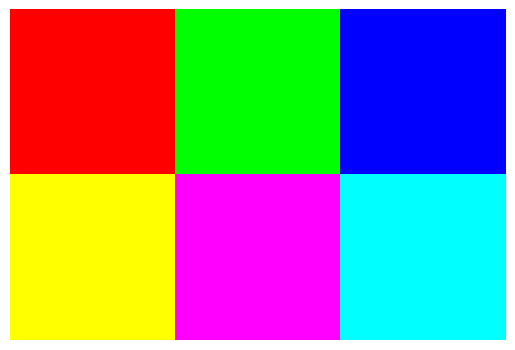

In [21]:
import matplotlib.pyplot as plt

plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [25]:
row = df_with_features_3d.select("features_3d").limit(1).collect()[0]
features_3d_list = row["features_3d"]

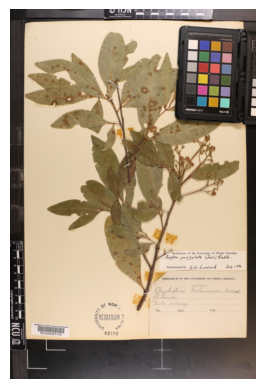

In [26]:
img_rgb = np.array(features_3d_list, dtype=np.float32)
img_rgb_uint8 = img_rgb.astype(np.uint8)

plt.imshow(img_rgb)
plt.axis("off")  # Hide axis ticks
plt.show()

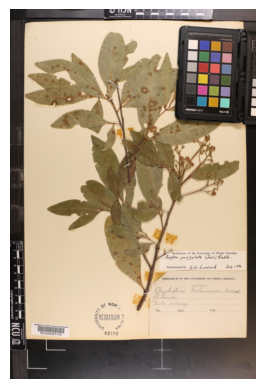

In [29]:
plt.imshow(img_rgb/255.0)
plt.axis("off")  # Hide axis ticks
plt.show()

In [31]:
df_with_features_3d.drop(col("image")).write.mode("overwrite").parquet("test/test_df_3d")

In [32]:
# Collect a single row
row = df_with_features_3d.limit(1).collect()[0]

# Convert the row data to its approximate size
def estimate_row_size(row):
    total_size = 0

    for column_name, value in row.asDict().items():
        if isinstance(value, list):
            # Recursively estimate size of lists
            total_size += estimate_list_size(value)
        elif isinstance(value, (str, int, float, bytes)):
            # Add size of primitive types
            total_size += sys.getsizeof(value)
        elif value is None:
            # Null values have negligible size
            continue
        else:
            # Handle other unexpected types
            total_size += sys.getsizeof(value)

    return total_size

def estimate_list_size(lst):
    """Recursively calculate size of a nested list."""
    total_size = sys.getsizeof(lst)  # Base size of the list object
    for item in lst:
        if isinstance(item, list):
            total_size += estimate_list_size(item)  # Recursively handle nested lists
        elif isinstance(item, (str, int, float, bytes)):
            total_size += sys.getsizeof(item)
        elif isinstance(item, np.ndarray):
            total_size += item.nbytes  # Size of NumPy arrays
        else:
            total_size += sys.getsizeof(item)
    return total_size

# Estimate size of the row
row_size_in_bytes = estimate_row_size(row)

print(f"Estimated row size: {row_size_in_bytes / 1024:.2f} KB")

Estimated row size: 68421.57 KB


In [ ]:
from pyspark.sql.functions import input_file_name

uuid_file_path_df = result_df.withColumn("file_path", input_file_name()).select("uuid", "file_path")
uuid_file_path_df.show(5, truncate=False)

# Save Images

This section demonstrates how to:

- Collect a subset of image data from a Spark DataFrame.
- Write batch images to disk, either sequentially or in parallel across multiple partitions.
- Optimize processing by repartitioning data for distributed execution and handling large datasets efficiently.

We use the following:

`save_images_partition`: A function that processes a spark data partition and iteratively writes images to disk.

`result_df`: A Spark DataFrame containing all images from museum specimens, with 9,490,931 rows.

`sample_df`: A smaller Spark DataFrame subset of result_df, containing 947 rows (674.93 MB).

In [18]:
import os
import io
import tarfile
import shutil

import numpy as np
from PIL import Image
from tqdm import tqdm

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.functions import col

spark= SparkSession.getActiveSession()

In [ ]:
sample_df = spark.read.parquet(f"{BASE_PATH}/gbif/image_lookup/multi_images_museum_specimen/group_id=0/part-00000-424c8415-fd13-41a6-8e35-6d99af3c9f79-c000.snappy.parquet")

In [ ]:
result_df = spark.read.parquet(f"{BASE_PATH}/gbif/image_lookup/multi_images_museum_specimen")

In [4]:
def decode_image_to_pil(row_data):
    """
    Decode binary image data from a DataFrame row and convert it to a PIL Image.

    Parameters:
    - row_data: pyspark.sql.Row
        A row containing `image`, `original_size`, and `resized_size` fields.

    Returns:
    - pil_image: PIL.Image.Image
        The decoded and converted PIL Image.
    """
    image_bytes = row_data["image"]

    try:
        # Try using the original size
        original_height, original_width = row_data["original_size"]
        img_array = np.frombuffer(image_bytes, dtype=np.uint8).reshape((original_height, original_width, 3))
    except Exception:
        # Fallback to resized size if original size is unavailable or invalid
        resized_height, resized_width = row_data["resized_size"]
        img_array = np.frombuffer(image_bytes, dtype=np.uint8).reshape((resized_height, resized_width, 3))

    # Convert BGR to RGB
    image = img_array[..., ::-1]

    # Convert NumPy array to PIL Image
    pil_image = Image.fromarray(image, mode="RGB")

    return pil_image

In [5]:
def compress_dir(dir_path, tar_file_path, compress=True):
    """
    Replace a folder with its TAR or TAR.GZ file.

    Parameters:
    - dir_path (str): Path to the folder to archive and delete.
    - tar_file_path (str): Path for the resulting TAR file (without .tar/.tar.gz extension).
    - compress (bool): Whether to compress the archive with Gzip (default True).
    """
    mode = "w:gz" if compress else "w"  # Compression mode
    extension = ".tar.gz" if compress else ".tar"
    tar_file_path += extension  # Add appropriate extension

    try:
        # Step 1: Create the TAR archive
        with tarfile.open(tar_file_path, mode) as tar:
            tar.add(dir_path, arcname=os.path.basename(dir_path))
        print(f"Successfully created TAR file: {tar_file_path}")

        # Step 2: Verify the TAR file creation
        if os.path.exists(tar_file_path):
            # Step 3: Delete the original folder
            shutil.rmtree(dir_path)
            print(f"Original folder '{dir_path}' deleted after archiving.")
        else:
            print(f"Error: TAR file not created. Folder '{dir_path}' was not deleted.")
    except Exception as e:
        print(f"Error during archiving or deletion: {e}")



In [6]:
def save_images_partition(rows, output_dir, compress = False):
    """
    Save images from a list of rows to the specified output directory.

    Parameters:
    - rows: iterable
        List of pyspark.sql.Row objects containing `image`, `original_size`, `resized_size`, and `uuid` fields.
    - output_dir: str
        The directory where images will be saved.
    """
    rows = list(rows)
    print(f"Processing {len(rows)} rows in partition by PID: {os.getpid()}")

    # Create the partition-specific directory
    partition_output_dir = os.path.join(output_dir, f"partition_{os.getpid()}")
    os.makedirs(partition_output_dir, exist_ok=True)
    
    # Wrap the rows in tqdm for progress tracking
    for row in tqdm(rows, desc=f"PID {os.getpid()} Progress", unit="image"):
        try:
            # Decode the image and get the UUID
            pil_image = decode_image_to_pil(row)
            uuid = row["uuid"]
            
            # Define the output file path and save the image
            output_path = os.path.join(partition_output_dir, f"{uuid}.png")
            pil_image.save(output_path)
            
        except Exception as e:
            print(f"Error saving image for UUID {row['uuid']}: {e}")
    print(f"Written {len(rows)} images to {partition_output_dir}")

    # Compresss folder into tar files
    if compress:
        print(f"Compressing...")        
        compress_dir(
            dir_path = partition_output_dir,
            tar_file_path = output_dir,
            compress = True
        )
        print(f"Images compressed into {output_dir}")

## Writing Images Sequentially from a Single Partition

In this step:

1. We collect 300 rows from `sample_df` into the **driver node** as a **single partition**.
2. Use `save_images_partition` to write all the images to disk. Since the data is collected to the driver node, progress is visible in the Jupyter session.

Since we are on the drivers node we can see the console progress output.

**Code Example: Writing Without Compression**

In [ ]:
output_dir = f"{BASE_PATH}/gbif/image_lookup/test/single_partition"
# Remove output directory generated from previous executions
shutil.rmtree(output_dir) if os.path.exists(output_dir) else None 


save_images_partition(sample_df.limit(300).collect(), output_dir, compress=False)

**Code Example: Writing With Compression**

To address file count restrictions on the OSC storage system, compress the images into a single TAR file. 

The compressed TAR file can be downloaded and viewed locally in a file explorer.

In [ ]:
shutil.rmtree(output_dir) if os.path.exists(output_dir) else None
save_images_partition(sample_df.limit(300).collect(), output_dir, compress=True)

## Writing Images in Parallel Across Multiple Partitions

Instead of collecting all data into the driver node, which is computationally expensive, we distribute the processing across worker nodes by:

1. Repartitioning data into your workers/executors.
2. Writing images for each partition in parallel.

Here, we limit the dataset to 900 rows and repartition it into 3 partitions, ensuring each partition contains 300 images.

**Code Example: Writing Without Compression**

In [ ]:
output_dir = f"{BASE_PATH}/gbif/image_lookup/test/multiple_partitions"
shutil.rmtree(output_dir) if os.path.exists(output_dir) else None

sample_df.limit(900).repartition(3).foreachPartition(lambda partition: save_images_partition(partition, output_dir, compress=False))

**Code Example: Writing With Compression**

In [ ]:
output_dir = f"{BASE_PATH}/gbif/image_lookup/test/multiple_partitions"
shutil.rmtree(output_dir) if os.path.exists(output_dir) else None

sample_df.limit(900).repartition(3).foreachPartition(lambda partition: save_images_partition(partition, output_dir, compress=True))

## Filtering Subsets and Write in Parallel

You can also create subset from the data using Spark's DataFrame API or SQL interface. 

Check the row count, and then repartition the data into moderate sizes, and then write to disk in parallel. 

For example, filter rows where `basisOfRecord` is `MATERIAL_CITATION`.

In [19]:
subset_df = (
    result_df
    .filter(col("basisOfRecord") == "MATERIAL_CITATION")
)
subset_df.count()

1395

Each workers are allocated with limited memory during the Spark initlization, therefore we want to limit the partition size to avoid out-of-memory error. My current spark session workers could easily handle 300 images writing tasks. 

So I'll repartition this subset into 5 partitions such that each workers will write approximately 220 images in one tar file.

In [ ]:
%%time
output_dir = f"{BASE_PATH}/gbif/image_lookup/test/materal_citation"
shutil.rmtree(output_dir) if os.path.exists(output_dir) else None

subset_df.repartition(5).foreachPartition(lambda partition: save_images_partition(partition, output_dir, compress = True))

CPU times: user 137 ms, sys: 29 ms, total: 166 ms
Wall time: 1min 25s
